### 1. Setup and importing Libraries

In [1]:
import os
import gc
import re
import json
import time
from pathlib import Path


import numpy as np
import pandas as pd


from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score


import lightgbm as lgb


# Text / NLP helpers
import nltk
nltk.download('punkt')


# Set seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 2. Data Loading

In [2]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
sub = pd.read_csv('/content/sample_submission.csv')


print('\nTrain shape:', train.shape)
print('Test shape:', test.shape)
print('\nTrain columns:', train.columns.tolist())


# Quick head
train.head()


Train shape: (269, 4)
Test shape: (264, 3)

Train columns: ['id', 'topic', 'answer', 'is_cheating']


,id,topic,answer,is_cheating
0,scr_cd3edac7d322,A girl wakes from a dream and she is not sure ...,"My eyes flew open, and the air around me feels...",1
1,scr_86f1104afb28,A journalistic review piece about the top 6 ai...,Robot Butlers in the year of 2025. What are th...,0
2,scr_c461dafbe886,The influence of fictional universities in cam...,"In recent years, apparel featuring the names a...",1
3,scr_64880cce429f,Why do girls love horses,"The moment before I hit the dirt, I thought we...",0
4,scr_c7742a3b2444,"Every year, a remote mountain town elects a ne...","In the valley of Eldermist, were the mountains...",1


###3. Exploratory Data Analysis

In [3]:
def basic_text_stats(df, text_col='answer'):
    df = df.copy()
    df['char_count'] = df[text_col].astype(str).apply(len)
    df['word_count'] = df[text_col].astype(str).apply(lambda x: len(x.split()))
    df['sentence_count'] = df[text_col].astype(str).apply(lambda x: len(nltk.tokenize.sent_tokenize(x)))
    return df[['char_count','word_count','sentence_count']]

##### Class Balance

In [4]:
if 'is_cheating' in train.columns:
  print('\nLabel distribution:')
  print(train['is_cheating'].value_counts(normalize=True))


Label distribution:
is_cheating
1    0.546468
0    0.453532
Name: proportion, dtype: float64


#### Text length summary

In [5]:
import nltk
import os

# Set NLTK data path explicitly
nltk_data_path = '/root/nltk_data'
if not os.path.exists(nltk_data_path):
    os.makedirs(nltk_data_path)
nltk.data.path.append(nltk_data_path)

nltk.download('punkt', download_dir=nltk_data_path)

print('\nTrain text length stats:')
print(basic_text_stats(train).describe())


Train text length stats:


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


        char_count   word_count  sentence_count
count   269.000000   269.000000      269.000000
mean   1053.052045   172.007435       10.535316
std     676.411116   121.382306        8.869055
min     142.000000    24.000000        1.000000
25%     803.000000   140.000000        6.000000
50%     983.000000   149.000000        8.000000
75%    1084.000000   157.000000       11.000000
max    6306.000000  1102.000000       76.000000


#### Topic distribution

In [6]:
if 'topic' in train.columns:
  print('\nTop topics (train):')
  print(train['topic'].value_counts().head(10))


Top topics (train):
topic
Fiction                                                                                                   2
The Unlikely Comeback of Analog Billboards in Smart Cities                                                1
Social Media - Connect Us                                                                                 1
The influence of weather on famous military blunders                                                      1
Secret Menus: The Quiet Weapon of Fast Food Chains                                                        1
A postman working the midnight shift starts delivering letters for people who died years ago.             1
Travel blog content creation                                                                              1
A child stumbles upon a locked garden where time passes differently for every plant.                      1
The social lives of octopuses: intelligence in invertebrates                                              1
H

#### Sanity check - show few positive and negative samples (first 2 each)

In [7]:
print('\nSample negative (is_cheating=0):')
print(train[train['is_cheating']==0]['answer'].head(2).tolist())
print('\nSample positive (is_cheating=1):')
print(train[train['is_cheating']==1]['answer'].head(2).tolist())


Sample negative (is_cheating=0):
['Robot Butlers in the year of 2025. What are they, what do they do, and where can you get one?\n\nIn this short article, we bring the future into the present and review the top 6 AI robot butlers available on the market in 2025 and go through the top brands, models, their cost, and where you can buy one for your home. ', 'The moment before I hit the dirt, I thought well that explains that. I crashed head first into the ground and heard the thunder of hooves narrowly miss me. Somewhere far, far away, I heard someone scream my name as the hoofbeats clattered down the lane back to the barn and faded. I couldn\'t feel my face or legs and stayed still as my stomach threatened to remind me of what I\'d eaten for lunch. Breathe, I reminded myself, just breathe. Inhale...ouch. That wasn\'t going to work for a second, so I closed my eyes and wished with all my heart that Pony was not so fond of bucking. She\'s a twister, my trainer said once, and he wasn\'t wr

### 4. Visualization

#### Word Clouds

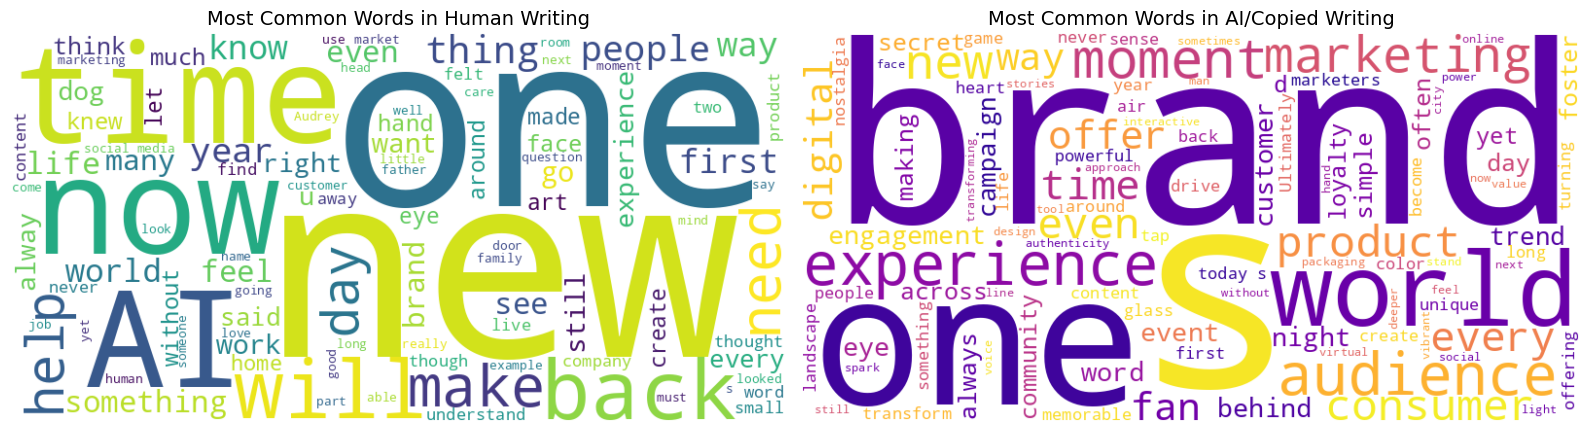

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Separate cheating and non-cheating texts
cheating_texts = ' '.join(train[train['is_cheating'] == 1]['answer'])
non_cheating_texts = ' '.join(train[train['is_cheating'] == 0]['answer'])

# Generate word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Non-cheating word cloud
wordcloud1 = WordCloud(width=800, height=400, background_color='white',
                       max_words=100, colormap='viridis').generate(non_cheating_texts)
ax1.imshow(wordcloud1, interpolation='bilinear')
ax1.set_title('Most Common Words in Human Writing', fontsize=14)
ax1.axis('off')

# Cheating word cloud
wordcloud2 = WordCloud(width=800, height=400, background_color='white',
                       max_words=100, colormap='plasma').generate(cheating_texts)
ax2.imshow(wordcloud2, interpolation='bilinear')
ax2.set_title('Most Common Words in AI/Copied Writing', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()

#### Readability Visualization

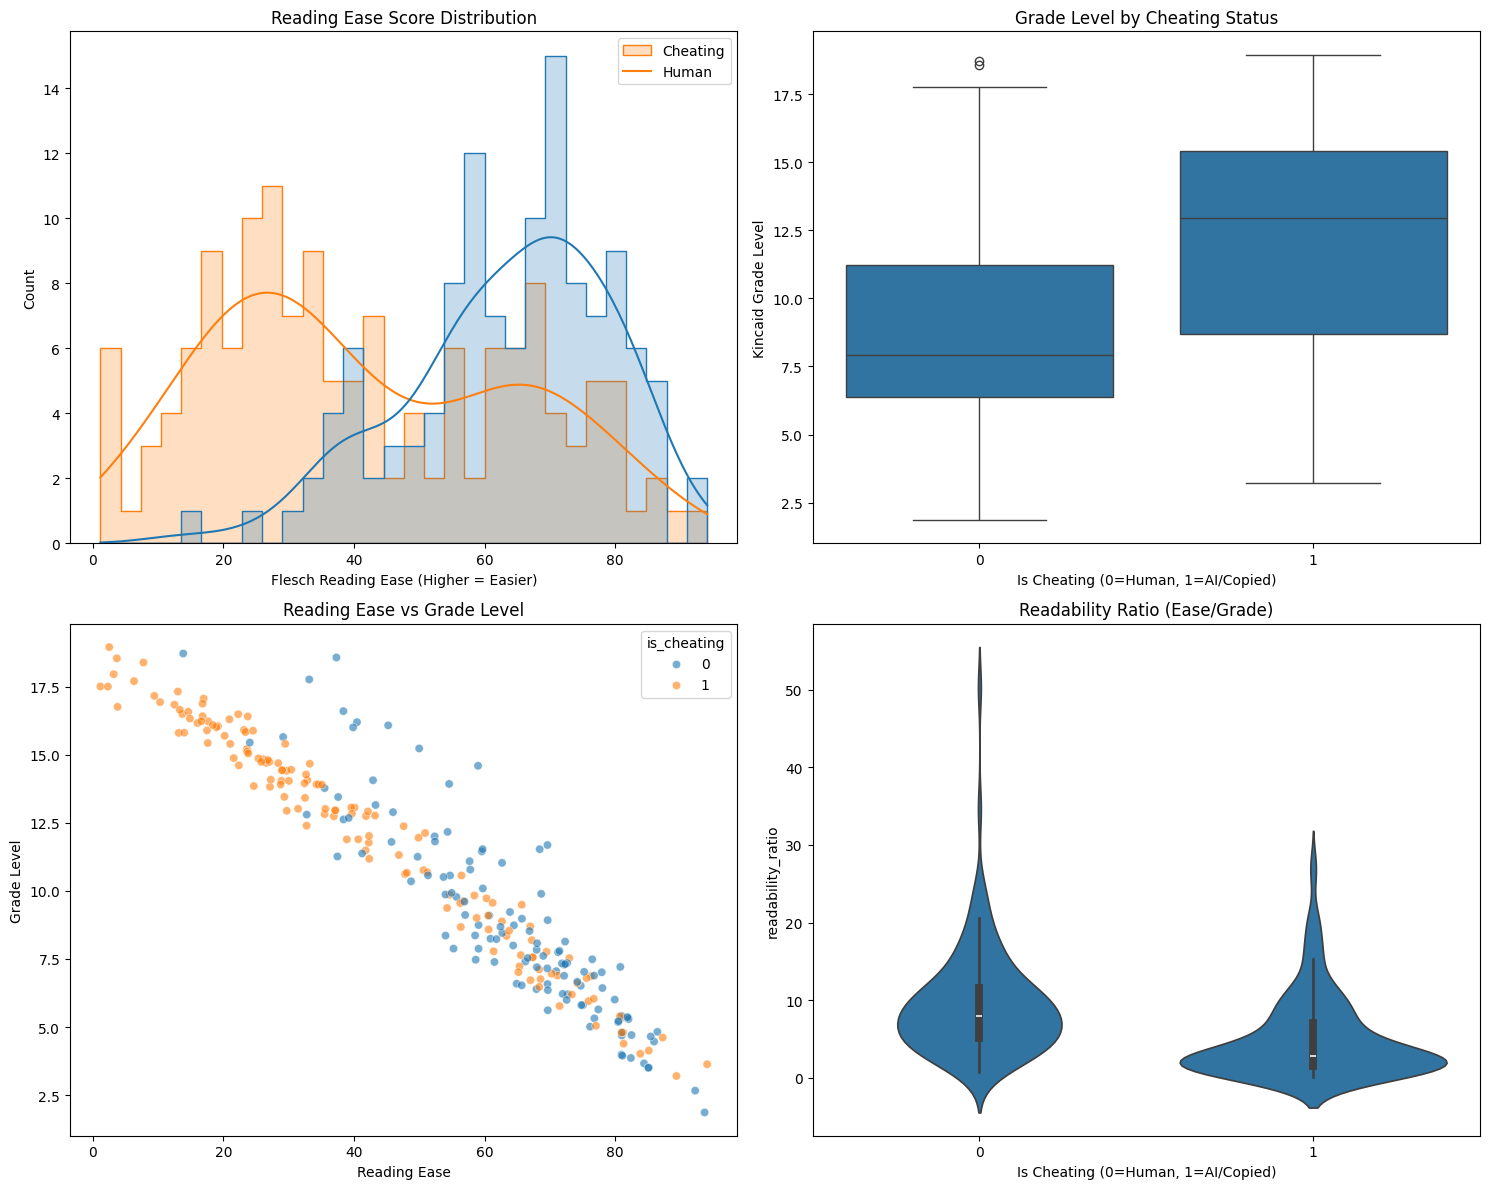

In [9]:
from textstat import flesch_reading_ease, flesch_kincaid_grade
import seaborn as sns

# Calculate readability scores
train['reading_ease'] = train['answer'].apply(flesch_reading_ease)
train['kincaid_grade'] = train['answer'].apply(flesch_kincaid_grade)

# Create comprehensive readability visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Reading Ease Distribution
sns.histplot(data=train, x='reading_ease', hue='is_cheating',
             bins=30, kde=True, ax=ax1, element='step')
ax1.set_title('Reading Ease Score Distribution')
ax1.set_xlabel('Flesch Reading Ease (Higher = Easier)')
ax1.legend(['Cheating', 'Human'])

# Grade Level Distribution
sns.boxplot(data=train, x='is_cheating', y='kincaid_grade', ax=ax2)
ax2.set_title('Grade Level by Cheating Status')
ax2.set_xlabel('Is Cheating (0=Human, 1=AI/Copied)')
ax2.set_ylabel('Kincaid Grade Level')

# Reading Ease vs Grade Level Scatter
sns.scatterplot(data=train, x='reading_ease', y='kincaid_grade',
                hue='is_cheating', alpha=0.6, ax=ax3)
ax3.set_title('Reading Ease vs Grade Level')
ax3.set_xlabel('Reading Ease')
ax3.set_ylabel('Grade Level')

# Combined readability score
train['readability_ratio'] = train['reading_ease'] / train['kincaid_grade']
sns.violinplot(data=train, x='is_cheating', y='readability_ratio', ax=ax4)
ax4.set_title('Readability Ratio (Ease/Grade)')
ax4.set_xlabel('Is Cheating (0=Human, 1=AI/Copied)')

plt.tight_layout()
plt.show()

#### Personalization Dashboard

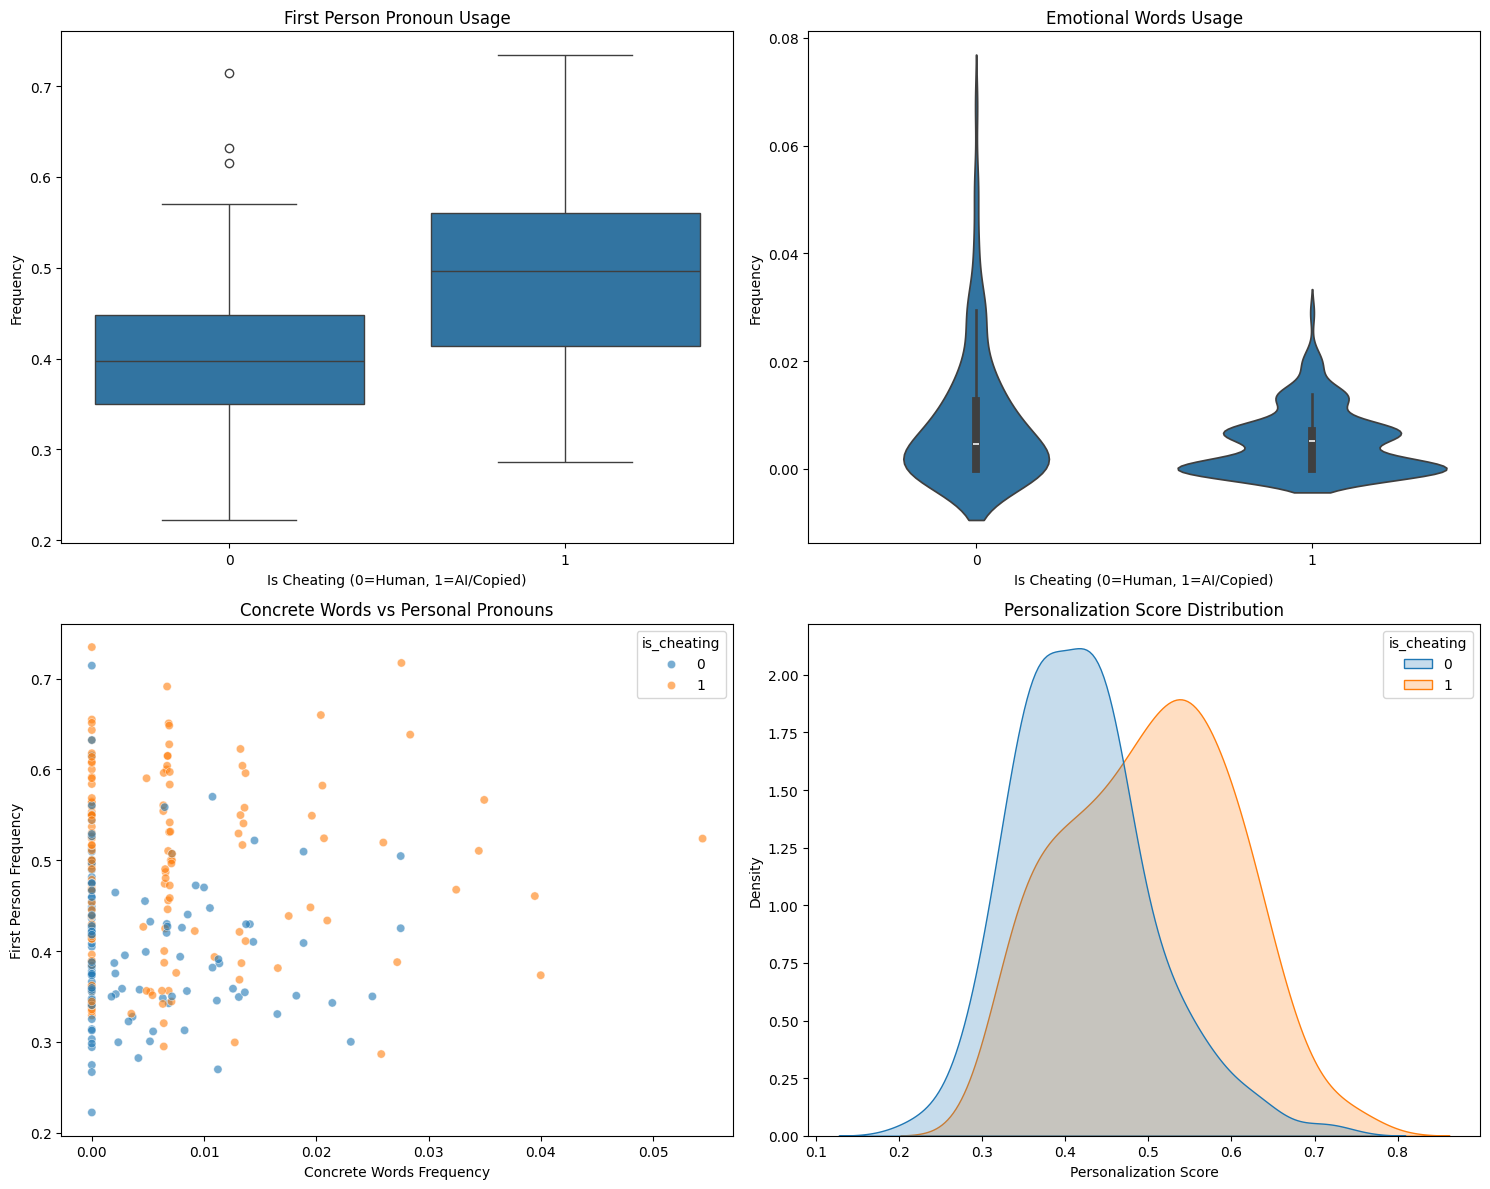

In [10]:
# Calculate personalization features
first_person = ['i', 'me', 'my', 'mine', 'myself', 'we', 'us', 'our', 'ours']
positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'love', 'like', 'enjoy']
negative_words = ['bad', 'terrible', 'awful', 'horrible', 'hate', 'dislike', 'poor']
concrete_words = ['table', 'chair', 'car', 'house', 'book', 'phone', 'computer', 'food', 'water']

train['first_person_freq'] = train['answer'].apply(
    lambda x: sum([x.lower().count(pronoun) for pronoun in first_person]) / len(x.split()) if len(x.split()) > 0 else 0
)
train['positive_freq'] = train['answer'].apply(
    lambda x: sum([x.lower().count(word) for word in positive_words]) / len(x.split()) if len(x.split()) > 0 else 0
)
train['negative_freq'] = train['answer'].apply(
    lambda x: sum([x.lower().count(word) for word in negative_words]) / len(x.split()) if len(x.split()) > 0 else 0
)
train['concrete_freq'] = train['answer'].apply(
    lambda x: sum([x.lower().count(word) for word in concrete_words]) / len(x.split()) if len(x.split()) > 0 else 0
)

# Create personalization dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# First Person Pronoun Usage
sns.boxplot(data=train, x='is_cheating', y='first_person_freq', ax=ax1)
ax1.set_title('First Person Pronoun Usage')
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Is Cheating (0=Human, 1=AI/Copied)')

# Emotional Words
train['emotional_freq'] = train['positive_freq'] + train['negative_freq']
sns.violinplot(data=train, x='is_cheating', y='emotional_freq', ax=ax2)
ax2.set_title('Emotional Words Usage')
ax2.set_ylabel('Frequency')
ax2.set_xlabel('Is Cheating (0=Human, 1=AI/Copied)')

# Concrete vs Abstract Language
sns.scatterplot(data=train, x='concrete_freq', y='first_person_freq',
                hue='is_cheating', alpha=0.6, ax=ax3)
ax3.set_title('Concrete Words vs Personal Pronouns')
ax3.set_xlabel('Concrete Words Frequency')
ax3.set_ylabel('First Person Frequency')

# Personalization Score
train['personalization_score'] = (train['first_person_freq'] +
                                    train['emotional_freq'] +
                                    train['concrete_freq'])
sns.kdeplot(data=train, x='personalization_score', hue='is_cheating',
            fill=True, ax=ax4)
ax4.set_title('Personalization Score Distribution')
ax4.set_xlabel('Personalization Score')
ax4.set_ylabel('Density')

plt.tight_layout()
plt.show()

### 5. Preprocessing

In [11]:
def minimal_clean(text):
    if pd.isna(text):
        return ''
    text = str(text)
    # normalize unicode and whitespace
    text = text.replace('\r',' ').replace('\n',' ').strip()
    text = re.sub(r'\s+', ' ', text)
    return text


train['answer'] = train['answer'].apply(minimal_clean)
test['answer'] = test['answer'].apply(minimal_clean)


# Drop exact duplicate rows in training (optional; keep track)
before = len(train)
train = train.drop_duplicates(subset=['answer']).reset_index(drop=True)
after = len(train)
print(f'\nDropped {before-after} exact duplicate answers from train')


Dropped 0 exact duplicate answers from train


### 6. Feature Engineering

In [12]:
import math
from collections import Counter


# Simple stylometry & doc stats
def doc_features(text):
    words = text.split()
    n_words = len(words)
    chars = len(text)
    sentences = nltk.tokenize.sent_tokenize(text)
    n_sents = max(1, len(sentences))
    avg_word_len = np.mean([len(w) for w in words]) if n_words>0 else 0
    unique_words = len(set(words))
    ttr = unique_words / max(1, n_words)
    punct_counts = Counter(ch for ch in text if ch in '.,;:!?"\'')
    uppercase_words = sum(1 for w in words if w.isupper())
    return {
    'char_count': chars,
    'word_count': n_words,
    'sent_count': n_sents,
    'avg_word_len': avg_word_len,
    'type_token_ratio': ttr,
    'upper_frac': uppercase_words / max(1, n_words),
    'comma_frac': text.count(',') / max(1, chars)
    }


# Apply to datasets
train_feats = pd.DataFrame(train['answer'].apply(doc_features).tolist())
test_feats = pd.DataFrame(test['answer'].apply(doc_features).tolist())


# Merge back
train = pd.concat([train.reset_index(drop=True), train_feats.reset_index(drop=True)], axis=1)
test = pd.concat([test.reset_index(drop=True), test_feats.reset_index(drop=True)], axis=1)


print('\nFeature sample:')
train[['char_count','word_count','type_token_ratio']].describe()


Feature sample:


,char_count,word_count,type_token_ratio
count,269.000000,269.000000,269.000000
mean,1049.003717,172.007435,0.753895
std,673.615437,121.382306,0.087334
min,142.000000,24.000000,0.468240
25%,790.000000,140.000000,0.705036
50%,979.000000,149.000000,0.774194
75%,1084.000000,157.000000,0.814815
max,6286.000000,1102.000000,0.947368


### 7. TF-IDF Baseline

In [13]:
# Parameters - tune for your data/compute
TF_MAX_FEATURES = 100000
TF_NGRAMS = (1,3)
MAX_FOLDS = 5


tfidf = TfidfVectorizer(ngram_range=TF_NGRAMS, max_features=TF_MAX_FEATURES, analyzer='word', min_df=2)
X_tfidf = tfidf.fit_transform(train['answer'])
X_test_tfidf = tfidf.transform(test['answer'])


y = train['is_cheating'].values


skf = StratifiedKFold(n_splits=MAX_FOLDS, shuffle=True, random_state=RANDOM_SEED)


oof_preds_tfidf = np.zeros(len(train))
test_preds_tfidf = np.zeros(len(test))


for fold, (tr_idx, val_idx) in enumerate(skf.split(X_tfidf, y)):
    print(f'Fold {fold+1}/{MAX_FOLDS}')
    X_tr = X_tfidf[tr_idx]
    X_val = X_tfidf[val_idx]
    y_tr = y[tr_idx]
    y_val = y[val_idx]


    clf = LogisticRegression(max_iter=2000, C=3.0, class_weight='balanced', solver='saga', random_state=RANDOM_SEED)
    clf.fit(X_tr, y_tr)
    oof_preds_tfidf[val_idx] = clf.predict_proba(X_val)[:,1]
    test_preds_tfidf += clf.predict_proba(X_test_tfidf)[:,1] / MAX_FOLDS


print('\nTF-IDF OOF AUC:', roc_auc_score(y, oof_preds_tfidf))


# Save OOF preds for stacking
train['oof_tfidf'] = oof_preds_tfidf
test['pred_tfidf'] = test_preds_tfidf

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

TF-IDF OOF AUC: 0.9567302330768372


### 8. LightGBM on engineered numeric features

In [14]:
feature_cols = ['char_count','word_count','sent_count','avg_word_len','type_token_ratio','upper_frac','comma_frac']


# Optionally reduce TF-IDF with TruncatedSVD and include as features (commented out for speed)
# from sklearn.decomposition import TruncatedSVD
# svd = TruncatedSVD(n_components=100, random_state=RANDOM_SEED)
# X_svd = svd.fit_transform(X_tfidf)
# for i in range(X_svd.shape[1]):
# train[f'svd_{i}'] = X_svd[:,i]


X = train[feature_cols].values
X_test = test[feature_cols].values


oof_preds_lgb = np.zeros(len(train))
test_preds_lgb = np.zeros(len(test))


for fold, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f'LGB Fold {fold+1}/{MAX_FOLDS}')
    X_tr, X_val_fold = X[tr_idx], X[val_idx]
    y_tr, y_val_fold = y[tr_idx], y[val_idx]


    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dval = lgb.Dataset(X_val_fold, label=y_val_fold, reference=dtrain)


    params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'seed': RANDOM_SEED,
    'verbosity': -1
    }
    model = lgb.train(params, dtrain, valid_sets=[dval], num_boost_round=1000,
                      callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=True),
                                 lgb.log_evaluation(period=100)])
    oof_preds_lgb[val_idx] = model.predict(X_val_fold)
    test_preds_lgb += model.predict(X_test) / MAX_FOLDS

# Store the validation data from the last fold
X_val = X_val_fold
y_val = y_val_fold


print('\nLGB OOF AUC on engineered features:', roc_auc_score(y, oof_preds_lgb))


train['oof_lgb'] = oof_preds_lgb
test['pred_lgb'] = test_preds_lgb

LGB Fold 1/5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.955556
Early stopping, best iteration is:
[52]	valid_0's auc: 0.969444
LGB Fold 2/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[9]	valid_0's auc: 0.970139
LGB Fold 3/5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.964138
Early stopping, best iteration is:
[91]	valid_0's auc: 0.966897
LGB Fold 4/5
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's auc: 0.938621
LGB Fold 5/5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.966954
Early stopping, best iteration is:
[75]	valid_0's auc: 0.971264

LGB OOF AUC on engineered features: 0.9371027099364337


### 9. Model Evaluation ROC-AUC

In [15]:
from sklearn.metrics import roc_auc_score

# Predict probabilities for validation data
y_pred = model.predict(X_val)

# Compute ROC-AUC
auc = roc_auc_score(y_val, y_pred)
print(f"Validation ROC-AUC: {auc:.4f}")

Validation ROC-AUC: 0.9713


### 10. Cross Validation

In [16]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []

for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train, y_valid = y[train_idx], y[valid_idx]

    # Create a new LightGBM Dataset for training and validation in each fold
    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)

    # Define LightGBM parameters (can be the same as in the previous cell)
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'seed': RANDOM_SEED,
        'verbosity': -1
    }

    # Train a new model instance for this fold
    model_fold = lgb.train(params, dtrain, valid_sets=[dvalid], num_boost_round=1000,
                           callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]) # verbose=False to reduce output during CV

    # Predict probabilities on the validation set for this fold
    y_pred = model_fold.predict(X_valid) # Use .predict for probabilities

    # Compute ROC-AUC for this fold
    auc = roc_auc_score(y_valid, y_pred)
    auc_scores.append(auc)
    print(f"Fold {fold} AUC: {auc:.4f}")

print(f"\nMean ROC-AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")

Fold 1 AUC: 0.9694
Fold 2 AUC: 0.9701
Fold 3 AUC: 0.9669
Fold 4 AUC: 0.9386
Fold 5 AUC: 0.9713

Mean ROC-AUC: 0.9633 ± 0.0124


### 11. Stack TF-IDF OOF and LGB OOF

In [17]:
meta_features = ['oof_tfidf','oof_lgb']
meta_X = train[meta_features].values
meta_y = train['is_cheating'].values


from sklearn.linear_model import LogisticRegression


meta_oof = np.zeros(len(train))
meta_test = np.zeros(len(test))


for fold, (tr_idx, val_idx) in enumerate(skf.split(meta_X, meta_y)):
    X_tr, X_val = meta_X[tr_idx], meta_X[val_idx]
    y_tr, y_val = meta_y[tr_idx], meta_y[val_idx]
    meta_clf = LogisticRegression(max_iter=1000)
    meta_clf.fit(X_tr, y_tr)
    meta_oof[val_idx] = meta_clf.predict_proba(X_val)[:,1]
    meta_test += meta_clf.predict_proba(test[ ['pred_tfidf','pred_lgb'] ].values)[:,1] / MAX_FOLDS


print('\nMeta OOF AUC:', roc_auc_score(meta_y, meta_oof))


train['oof_meta'] = meta_oof
test['pred_meta'] = meta_test


Meta OOF AUC: 0.9594624735139957


### 12. Calibrate probabilities

In [18]:
if 'topic' in train.columns:
    topic_aucs = []
    for t, grp in train.groupby('topic'):
        if len(grp) < 20:
            continue
        try:
            auc = roc_auc_score(grp['is_cheating'], grp['oof_meta'])
            topic_aucs.append((t, auc, len(grp)))
        except Exception:
            continue
    topic_aucs = sorted(topic_aucs, key=lambda x: x[1])
    print('\nSample per-topic AUC (low->high):')
    print(topic_aucs[:10])


# Adversarial validation (train vs test) using tfidf quick check
from sklearn.model_selection import train_test_split
adv_X = np.vstack([X_tfidf.toarray(), X_test_tfidf.toarray()]) if X_tfidf.shape[0] < 5000 else None
# If dataset too large, skip or use sampled rows for adv validation
if adv_X is not None:
    adv_y = np.concatenate([np.zeros(X_tfidf.shape[0]), np.ones(X_test_tfidf.shape[0])])
    adv_clf = LogisticRegression(max_iter=500)
    adv_clf.fit(adv_X, adv_y)
    adv_pred = adv_clf.predict_proba(adv_X)[:,1]
    try:
        print('\nAdversarial AUC (train vs test):', roc_auc_score(adv_y, adv_pred))
    except Exception:
        pass
else:
    print('\nAdv validation skipped due to size - sample your data if you want this check')


Sample per-topic AUC (low->high):
[]

Adversarial AUC (train vs test): 0.9908471330404416


### 13. Submission

In [19]:
submission = test[['id', 'pred_meta']].copy()
submission.rename(columns={'pred_meta': 'is_cheating'}, inplace=True)
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")

Submission file created successfully!
